In [21]:
%run header.py data/ASIC-2-FPGA

# A quick look

In [22]:
df.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,CP_delay,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,FU.1,ATTR,ARRAY_1,LOOP_1,FUNC_1,FUNC_2,Attr,Attr_with_L,Slices
0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,-,1.4275ns,-,-,-,-,21,-,-,100,Cyber,array=RAM,folding=1,func=goto,func=inline,ATTR=Cyber;ARRAY_1=array=RAM;LOOP_1=folding=1;...,ATTR=Cyber;ARRAY_1=array=RAM;LOOP_1=folding=1;...,394
1,1574,4,670,636,238,0,2935,1337,4,4,4.0,30,-,2.6575ns,-,-,-,-,21,-,-,-100,Cyber,array=RAM,folding=1,func=inline,func=goto,ATTR=Cyber;ARRAY_1=array=RAM;LOOP_1=folding=1;...,ATTR=Cyber;ARRAY_1=array=RAM;LOOP_1=folding=1;...,356


In [23]:
df_fixed.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,0,0,0,0,0,21,0,0,394
1,1574,4,670,636,238,0,2935,1337,4,4,4.0,30,0,0,0,0,0,21,0,0,356


In [24]:
df_labeled.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices,PF_ASIC,PF_FPGA,WithTolerance,WithToleranceL
0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,0,0,0,0,0,21,0,0,394,False,False,False,False
1,1574,4,670,636,238,0,2935,1337,4,4,4.0,30,0,0,0,0,0,21,0,0,356,False,True,False,False


In [25]:
df_scaled.head(2)

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices,PF_ASIC,PF_FPGA,WithTolerance,WithToleranceL
0,1846,0.1481,-0.5262,0.3926,-1.5082,0.0,-0.7903,-0.7649,0.1481,0.1481,0.1481,0.037,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,394,False,False,False,False
1,1574,0.1481,-0.7906,0.3926,-1.3040,0.0,-0.9001,-0.8888,0.1481,0.1481,0.1481,0.037,0.0,0.0,0.0,0.0,0.0,21,0.0,0.0,356,False,True,False,False


# Train and predict a single benchmark

In [38]:
def train_predict(estimator, df, features, label='Slices', kind='train', normalize=False):
    X, y = ML.separate_feature_label(df, valid_features=features, label=label)
    
    if normalize:
        X = ML.feature_scaling(X)
    
    if kind == 'train':
        estimator.fit(X, y)
        return estimator
    elif kind == 'test':
        y_pred = estimator.predict(X)
        df_ret = df.copy()
        df_ret['AREA'] = y_pred
        return df_ret

In [39]:
estimator = linear_model.LinearRegression()
estimator = train_predict(estimator, df_scaled, valid_features)
df_pred = train_predict(estimator, df_scaled, valid_features, kind='test')

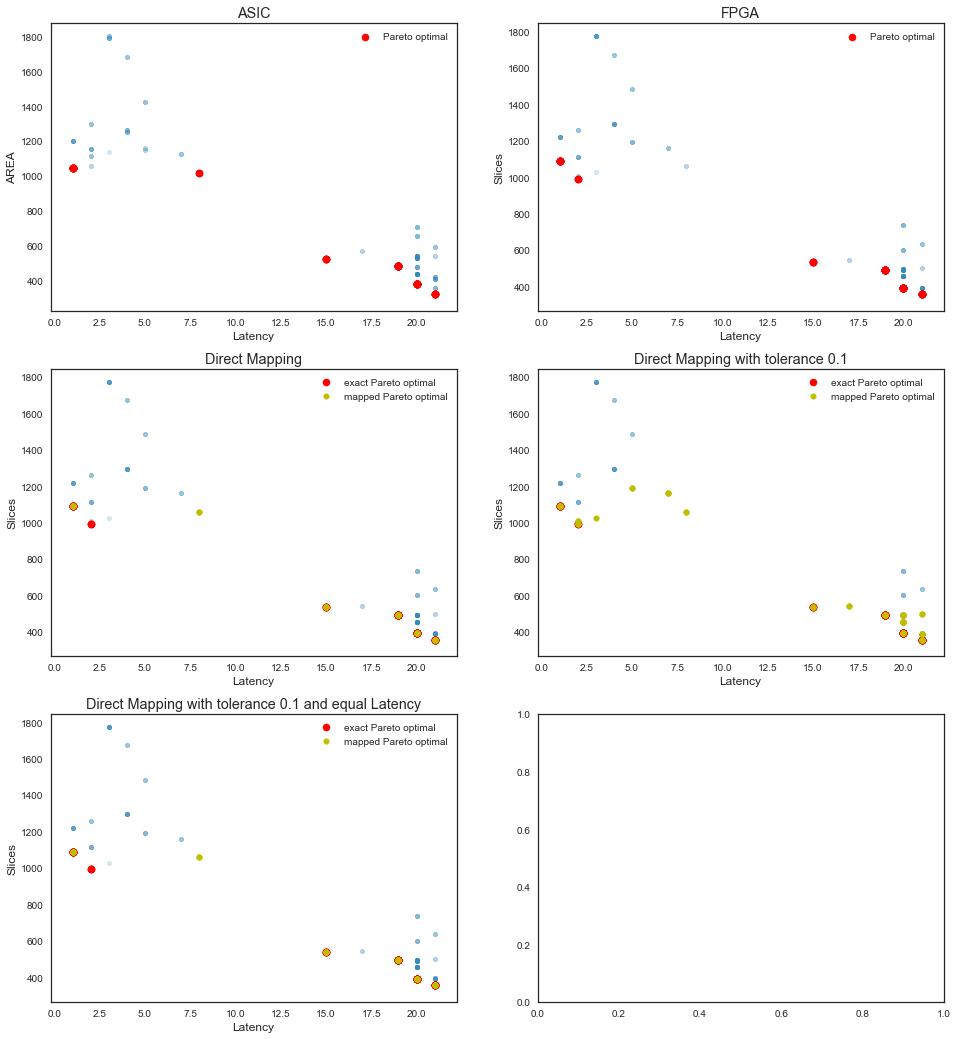

{'adrs_ave': 0.016297043010752688,
 'adrs_ave_rms': 0.011469095081416603,
 'adrs_max': 0.09778225806451613,
 'adrs_max_rms': 0.06881457048849962,
 'cardinality': 58,
 'dominance': 0.8333333333333334,
 'hypervolume': 0.9649179285459639}

In [44]:
# predicted
dm.main(df_pred, tolerance=0.1, plot_figure=True)
dm.results_no_tol

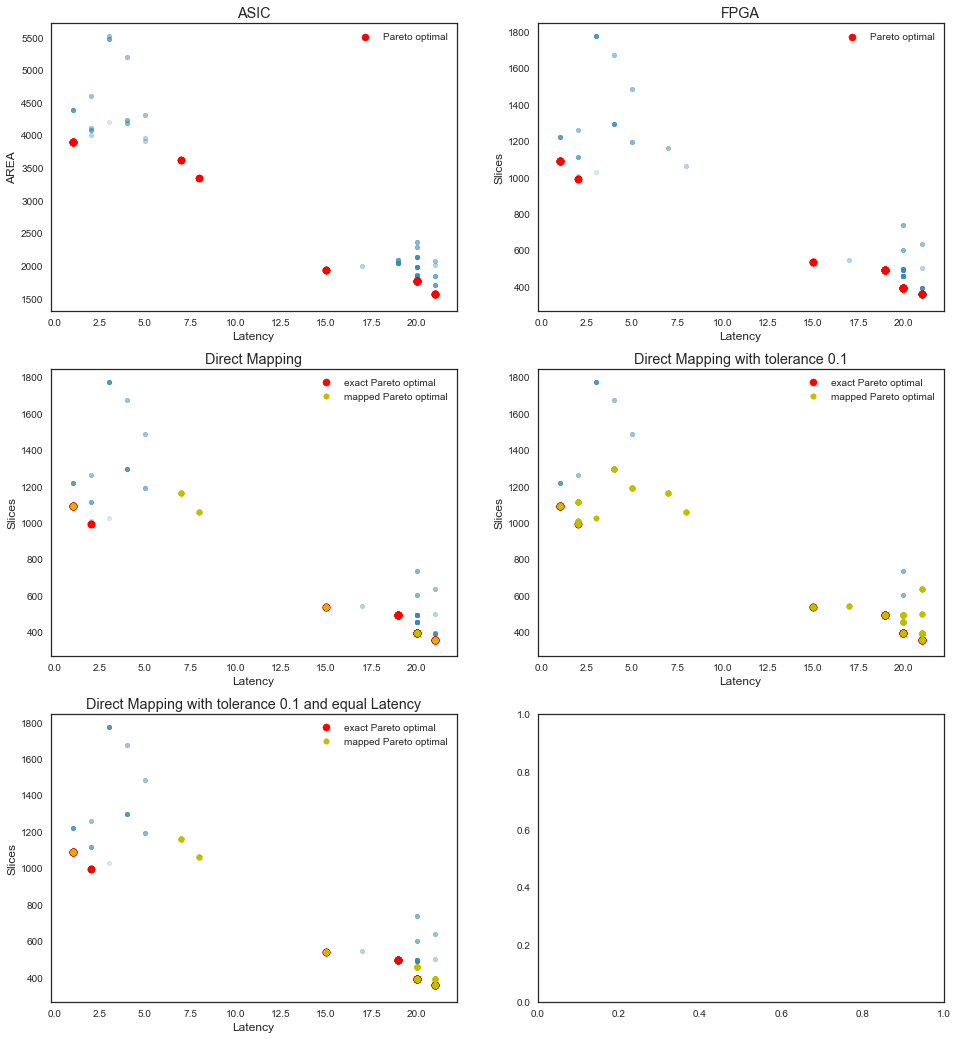

{'adrs_ave': 0.02506897283531409,
 'adrs_ave_rms': 0.026057874556347293,
 'adrs_max': 0.09778225806451613,
 'adrs_max_rms': 0.08753267684958413,
 'cardinality': 45,
 'dominance': 0.6666666666666666,
 'hypervolume': 0.27220855398845356}

In [46]:
# direct mapping
dm.main(df_scaled, tolerance=0.1, plot_figure=True)
dm.results_no_tol

# Train merged benchmarks

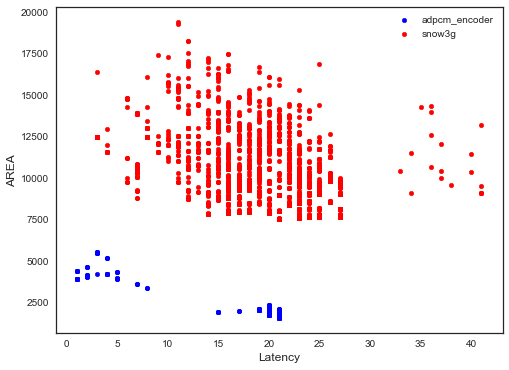

In [71]:
benchmark_train = ['adpcm_encoder', 'snow3g']
benchmark_test = ['aes', 'fft_fixed']

# merge benchmarks as training set
df_train = pd.concat([dict_df_scaled[i] for i in benchmark_train], axis=0, ignore_index=True)

# see the merged data distribution
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
l_color = ['b', 'r', 'y']  # colors
for i, v in enumerate(benchmark_train):
    dict_df_scaled[v].plot(kind='scatter', x='Latency', y='AREA', ax=axes, c=l_color[i], label=benchmark_train[i])
plt.show()

In [72]:
# train the model
estimator = linear_model.LinearRegression()
estimator = train_predict(estimator, df_train, valid_features)

In [79]:
# predict the test benchmarks
df_pred = dict()
for i in benchmark_test:
    df_pred[i] = train_predict(estimator, dict_df_scaled[i], valid_features, kind='test')

# Exhaustive search

In [ ]:
def train_es(data=None, estimator=None, result_fn=None):
    scores_all = dict()
    for benchmarks_cnt in range(1, len(benchmarks)):
        scores = dict()
        for benchmarks_train in itertools.combinations(benchmarks, benchmarks_cnt):
            benchmarks_test = (i for i in benchmarks if i not in benchmarks_train)
            data_train = pd.concat([data[i] for i in benchmarks_train], axis=0, ignore_index=True)
            estimator = execute(data_train, estimator, kind='training')
            key = ';'.join(list(benchmarks_train))
            scores[key] = dict()
            for benchmark_test in benchmarks_test:
                scores[key][benchmark_test] = execute(data[benchmark_test], estimator, kind='testing')
        scores_all[str(benchmarks_cnt)] = scores
        
    with open(result_fn, 'w') as f:
        f.write('train,test,adrs_ave,adrs_max,adrs_ave_rms,adrs_max_rms,hypervolume,dominance,cardinality\n')
        for bench_cnt in scores_all.keys():
            for training, testing in scores_all[bench_cnt].items():
                for k, v in testing.items():
                    f.write(training + ',' + k + ',' + ','.join([f'{i:.4f}' for i in v.values()]) + '\n')
                    
    return scores_all

In [ ]:
%%time
scores_v4_lr = train_es(data=gd.data_v4, estimator=estimators[0], result_fn='es_train_lr.csv')

In [ ]:
%%time
scores_v4_ada = train_es(data=gd.data_v4, estimator=estimators[-2], result_fn='es_v4_ada.csv')